In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rewards = pd.read_csv('Ads_CTR_Optimisation.csv')

In [3]:
rewards.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


# Random Selection
What would be the success rate if we selected a random ad for each user (at each round)?

In [9]:
N = rewards.shape[0]
d = rewards.shape[1]

In [31]:
random_selection = (np.random.choice(range(d), size=(N, 1)) == np.arange(d)).astype(int)
random_selection[:5]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [32]:
is_selected = ((rewards.values==1) & (random_selection==1)).sum(axis=1)

**Success rate**:

In [33]:
is_selected.mean()

0.1255

For a more confident random selection benchmark, we can perform random selection for 10,000 times.

In [233]:
random_selection = (np.random.choice(range(d), size=(N, 1, 10000)) == np.tile(np.arange(d).reshape(-1, 1), (1,10000))).astype(int)

In [241]:
((rewards.values==1).reshape(10000, 10, 1) & (random_selection==1)) \
    .sum(axis=1) \
    .mean(axis=0) \
    .mean()

0.12384629999999999

# Upper Confidence Bound

- **Step 1**: At each round $n$, we consider two numbers for each ad $i$:
    - $N_i(n)$ - the number of times the ad $i$ was selected up to round $n$,
    - $R_i(n)$ - the sum of rewards of the ad $i$ up to round $n$.  

In [10]:
def initiate_ad_data():
    """Initiate a global ad data dict."""
    global ad_data
    ad_data = {ad:{'Ni':0, 'Ri':0, 'UCB':1e5} for ad in range(d)}

- **Step 2**: From there two numbers we compute:
    - the average reward of ad $i$ up to round $n$
$$\bar{r_i}(n) = \frac{R_i(n)}{N_i(n)}$$
    - the confidence interval $[\bar{r_i}(n) - \Delta_i(n), \bar{r_i}(n) + \Delta_i(n)]$ at round $n$ with
$$\Delta_i(n) = \sqrt{\frac{3}{2} \frac{log(n)}{N_i(n)}}$$

In [11]:
def check_reward(ad, actual):
    """Check reward against actual rewards table."""
    ad = ad == np.arange(d)
    return ((ad == 1) & (actual == 1)).sum()

def calculate_ucb(Ni, Ri, n):
    """Calculat UCB using Ni, Ri and n (round)."""
    r_bar = Ri / Ni
    delta_i = np.sqrt(3 / 2 * np.log(n + 1) / Ni) # round never starts from 0
    return r_bar + delta_i

- **Step 3**: We select the ad $i$ having the maximum **UCB** $\bar{r_i}(n) + \Delta_i(n)$.

In [12]:
def select_ad(ad_data):
    """Select the ad having maximum UCB."""
    return max(ad_data.items(), key=lambda x: x[1]['UCB'])[0]

In [13]:
def update_ad(ad, reward, ad_data, round_number):
    """Update ad info. Selection count, total reward and UCB is updated."""
    ad_data[ad]['Ni'] += 1
    ad_data[ad]['Ri'] += reward
    ad_data[ad]['UCB'] = calculate_ucb(ad_data[ad]['Ni'],
                                       ad_data[ad]['Ri'],
                                       round_number)

### Implementation for one round

In [14]:
initiate_ad_data()

In [15]:
round_ = 0
selected = select_ad(ad_data)
print('selected ad:', selected)
current_reward = check_reward(selected, rewards.loc[round_])
print('current reward: ', current_reward)
update_ad(selected, current_reward, ad_data, round_)
ad_data

selected ad: 0
current reward:  1


{0: {'Ni': 1, 'Ri': 1, 'UCB': 1.0},
 1: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 2: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 3: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 4: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 5: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 6: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 7: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 8: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0},
 9: {'Ni': 0, 'Ri': 0, 'UCB': 100000.0}}

### Implementation for all rounds:

In [16]:
%%time
initiate_ad_data()
for round_ in range(N):
    selected = select_ad(ad_data)
    current_reward = check_reward(selected, rewards.loc[round_])
    update_ad(selected, current_reward, ad_data, round_)

Wall time: 5.05 s


In [17]:
ad_frame = pd.DataFrame(ad_data).T
ad_frame

,Ni,Ri,UCB
0,1011.0,200.0,0.314674
1,371.0,45.0,0.314229
2,220.0,14.0,0.314189
3,473.0,68.0,0.314590
4,5954.0,1591.0,0.315386
5,146.0,1.0,0.314323
6,338.0,38.0,0.314512
7,1050.0,210.0,0.314661
8,261.0,22.0,0.314307
9,176.0,6.0,0.314167


In [18]:
ad_frame[['Ni', 'Ri']].sum()

Ni    10000.0
Ri     2195.0
dtype: float64

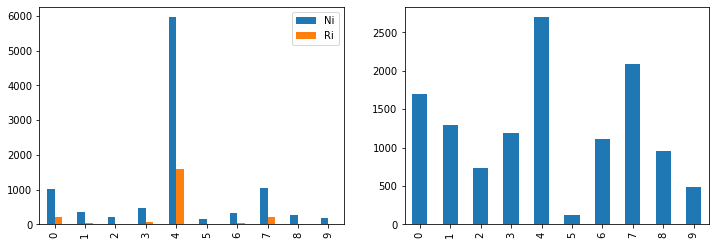

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ad_frame.plot(kind='bar', y=['Ni', 'Ri'], ax=ax[0])
rewards.rename({k:v for k,v in zip(rewards.columns, range(d))}, axis=1).sum().plot(kind='bar', ax=ax[1])

## Takeaways:
- Clickthrough rate has been **increased by 100%**.